In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
from generator import SkillsGenerator, DatasetGenerator
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
import gen_prompt_template
from importlib import reload
import pickle
from api_key import API_KEY
import seaborn as sns
tqdm.pandas()


%load_ext autoreload
%autoreload 2

In [2]:
## Loading the embedded taxonomy
ESCO_DIR = "../../../../esco/"

with open(ESCO_DIR + "dev_skillspan_emb.pkl", "rb") as f:
    dev_emb_tax = pickle.load(f)
    dev_emb_tax["embeddings"] = dev_emb_tax["embeddings"].apply(lambda x : x.detach())

with open(ESCO_DIR + "test_skillspan_emb.pkl", "rb") as f:
    test_emb_tax = pickle.load(f)
    test_emb_tax["embeddings"] = test_emb_tax["embeddings"].apply(lambda x : x.detach())

## create train emb tax
train_emb_tax = pd.concat([test_emb_tax, dev_emb_tax]).drop_duplicates("name")


## get taxonomy without embeddings
dev_tax = dev_emb_tax.drop("embeddings", axis=1)
test_tax = test_emb_tax.drop("embeddings", axis=1)
train_tax = train_emb_tax.drop("embeddings", axis=1)


## popularity distribution
F = pd.read_csv("../ppl_3_sentences_all_skills.csv").drop("Unnamed: 0", axis=1)[["name", "mean_std_ppl"]].set_index("name").to_dict()["mean_std_ppl"]

## skill nb distribution
MAX_NB_SKILL = 5
combination_dist = np.ones(MAX_NB_SKILL) / MAX_NB_SKILL

## Models
word_emb = "jjzha/jobbert-base-cased"
word_emb_model = AutoModel.from_pretrained(word_emb)
word_emb_tokenizer = AutoTokenizer.from_pretrained(word_emb)

## Not used in this version
additional_info = None


Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of combinations in train split : 6000
Number of combinations in test split : 1200
Number of combinations in dev split : 1200


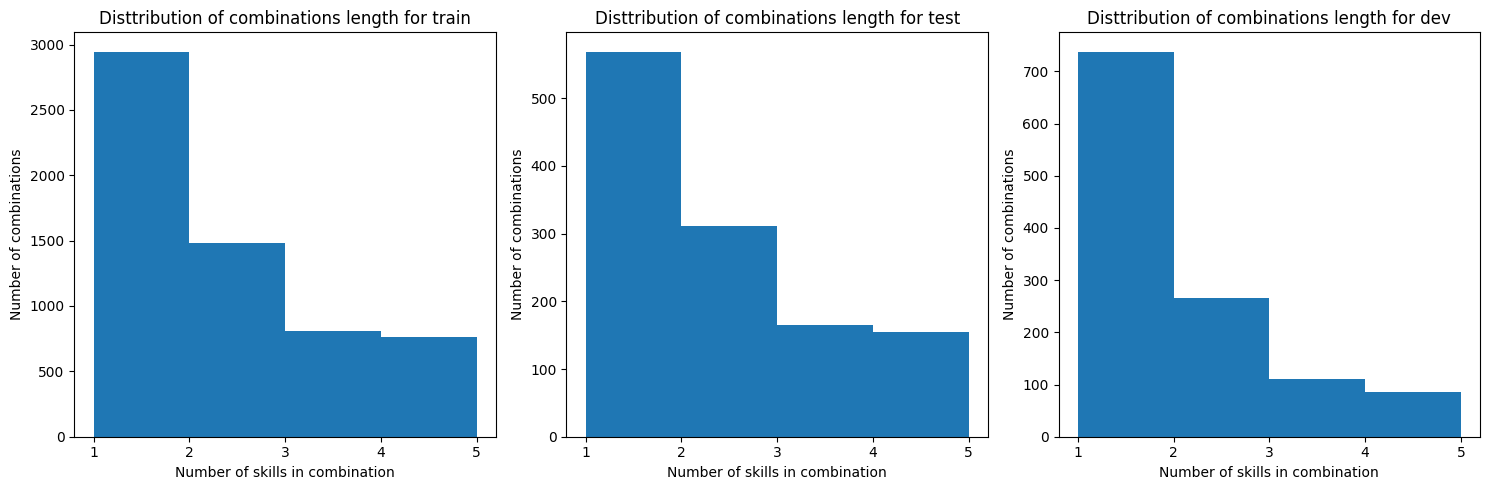

In [3]:
def combinations_generation(emb_tax, split_size):
    gen = SkillsGenerator(taxonomy=emb_tax, 
                taxonomy_is_embedded=True,
                combination_dist=combination_dist,
                popularity=F)
    
    gen_args = {
        "nb_generation" : split_size, # number of samples
        "threshold" : 0.83, # not considering skills that are less than .8 similar
        "beam_size" : 20, # considering 20 skills
        "temperature_pairing": 1, # popularity to be skewed toward popular skills
        "temperature_sample_size": 1,
        "frequency_select": True, # wether we select within the NN acording to frequency
    }


    combinations = list(gen.balanced_nbred_iter(**gen_args))
    return combinations

f, a = plt.subplots(1, 3, figsize=(15, 5))

split_sizes = {
    "train": 0.75,
    "test": 0.15,
    "dev": 0.15,
}
split_emb_taxs = {
    "train": train_emb_tax,
    "test": test_emb_tax,
    "dev": dev_emb_tax,
}
TOTAL_SAMPLES = 8_000

combinations = {}
for ax, split in zip(a.flatten(), split_sizes):
    combinations[split] = combinations_generation(split_emb_taxs[split], int(TOTAL_SAMPLES * split_sizes[split]))
    ax.hist([len(x) for x in combinations[split]], bins=np.arange(1,6))
    ax.set_title(f"Disttribution of combinations length for {split}")
    ax.set_ylabel("Number of combinations")
    ax.set_xlabel("Number of skills in combination")
    ax.set_xticks(np.arange(1,6))
    print(f"Number of combinations in {split} split : {len(combinations[split])}")

plt.tight_layout()

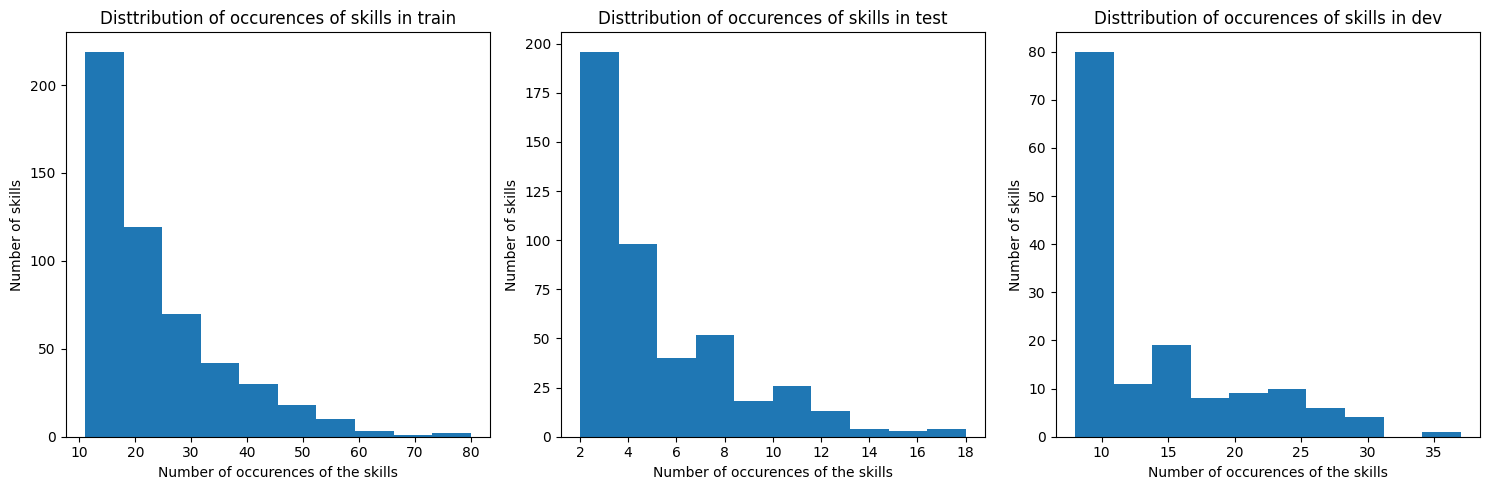

In [4]:
from collections import Counter
def occurences_lookup(combinations):
    flatten_dist = sum(combinations, [])
    counts = Counter(flatten_dist).values()
    return counts


f, a = plt.subplots(1, 3, figsize=(15, 5))
for ax, split in zip(a.flatten(), split_sizes):
    split_dist = occurences_lookup(combinations[split])
    ax.hist(split_dist)
    ax.set_title(f"Disttribution of occurences of skills in {split}")
    ax.set_ylabel("Number of skills")
    ax.set_xlabel("Number of occurences of the skills")
    

plt.tight_layout()

In [5]:
flatten_tests = set(sum(combinations["test"], []) + sum(combinations["dev"], []))
flatten_train = set(sum(combinations["train"], []))

print(flatten_tests.difference(flatten_train)) ## = set (), so all the test sample are represented at least once in the train

set()


In [6]:
def generate_split(split, n_samples=None):
    combs = combinations[split]

    if(n_samples is None):
        n_samples = len(combs)
    
    emb_tax = split_emb_taxs[split]
    datagen = DatasetGenerator(emb_tax,
                           None, ## no references, we work in Zero-Shot
                           word_emb_model,
                           word_emb_tokenizer,
                           additional_info)

    generation_args = {
        "skill_generator": combs[:n_samples], 
        "specific_few_shots": False,
        "model": "gpt-3.5",
        "gen_mode": "PROTOTYPE",
        "autosave": True,
        "autosave_file": f"generated/SKILLSPAN/{split}.json",
        "checkpoints_freq":10
    }
    res = datagen.generate_ds(**generation_args)
    return res
    
    

In [13]:
## we need to look for few shots for PAPERV2 prompting
gt = pd.read_csv("../../../data/processed/real/job_offers_sentences.csv")
gt = gt[gt.columns[2:]]
list(gt.sentences)

['Full stack engineer 80-100% (f/m/d)For our client, one of the global leader in respiratory care for intensive care units, we are looking for an experienced Fullstack Software Engineer to join our growing Digital Solutions Group',
 'In this role, you will develop and maintain applications running on the cloud',
 'You are open to exploring and adapting new technologies and frameworks and will be challenged with tasks in the analysis and design of the software, as well as in quality assurance',
 'Your tasks Analysis & design of innovative software solutions Implementation & testing of new software features, as well as maintenance and operation of released software Work closely with other engineers and product managers to deliver high-quality software products',
 'Your profile To solve these tasks in the best possible way, we envision candidates with a degree in engineering (university / technical college) with in-depth knowledge of technical computer science',
 'Experience in developing

In [15]:
split = "dev"
path = ESCO_DIR + split + ".json"
with open(path) as f:
    split_records = eval(", ".join(f.read().split("\n")))

In [18]:
split_records[30]

{'idx': 30,
 'tokens': 'As a person you are outgoing of nature and you possess natural project management skills',
 'labels': ['UNK', 'project management']}